In [31]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support
)

from src.features.vectorizer import create_vectorizer

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de entrenamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías importadas correctamente
📅 Fecha de entrenamiento: 2025-12-10 17:41:40


📦 Dataset cargado: 31635 muestras, 3 columnas

📋 Distribución de clases:
label
Depression    15085
Suicidal      10641
Anxiety        3614
Stress         2295
Name: count, dtype: int64

📊 Proporción de clases:
label
Depression    0.477
Suicidal      0.336
Anxiety       0.114
Stress        0.073
Name: proportion, dtype: float64


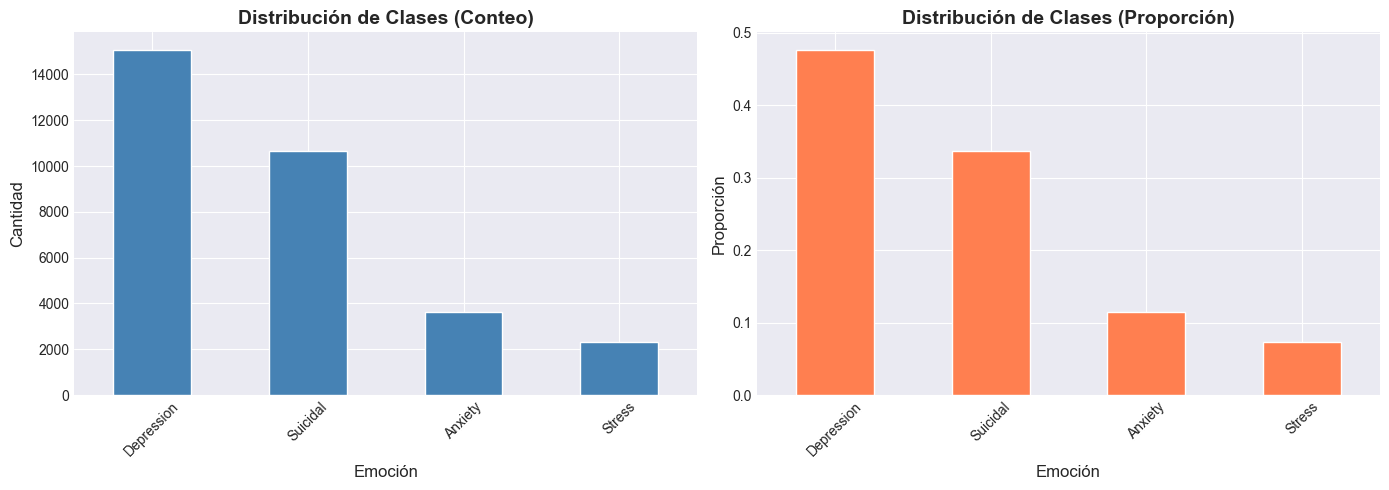


❓ Valores nulos: 5


In [32]:
# Cargar dataset preprocesado
df = pd.read_csv("../../data/processed/cleaned_dataset.csv")

print(f"📦 Dataset cargado: {df.shape[0]} muestras, {df.shape[1]} columnas")
print(f"\n📋 Distribución de clases:")
print(df['label'].value_counts())
print(f"\n📊 Proporción de clases:")
print(df['label'].value_counts(normalize=True).round(3))

# Visualizar distribución
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df['label'].value_counts().plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('Distribución de Clases (Conteo)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Emoción', fontsize=12)
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

df['label'].value_counts(normalize=True).plot(kind='bar', ax=ax[1], color='coral')
ax[1].set_title('Distribución de Clases (Proporción)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Emoción', fontsize=12)
ax[1].set_ylabel('Proporción', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n❓ Valores nulos: {df.isnull().sum().sum()}")

In [33]:
X = df["clean_text"]
y = df["label"]

# Split estratificado para mantener proporciones
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✂️ División del dataset:")
print(f"  Train: {len(X_train)} muestras ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test)} muestras ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n📊 Distribución en Train:")
print(y_train.value_counts())
print(f"\n📊 Distribución en Test:")
print(y_test.value_counts())

✂️ División del dataset:
  Train: 25308 muestras (80.0%)
  Test:  6327 muestras (20.0%)

📊 Distribución en Train:
label
Depression    12068
Suicidal       8513
Anxiety        2891
Stress         1836
Name: count, dtype: int64

📊 Distribución en Test:
label
Depression    3017
Suicidal      2128
Anxiety        723
Stress         459
Name: count, dtype: int64


In [34]:
# LIMPIEZA CORRECTA — se limpia ANTES DEL SPLIT
df = df.dropna(subset=["clean_text", "label"]).copy()
df["clean_text"] = df["clean_text"].astype(str)
df = df[df["clean_text"].str.strip() != ""]
df = df[df["clean_text"].str.lower() != "nan"]
df = df[df["clean_text"].str.lower() != "none"]
df = df.reset_index(drop=True)

print("Dataset limpio:", df.shape)

# AHORA SÍ, HACER SPLIT
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(len(X_train), len(y_train))

# Crear y ajustar vectorizador
vectorizer = create_vectorizer(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"📐 Dimensiones de matrices:")
print(f"  X_train: {X_train_vec.shape}")
print(f"  X_test:  {X_test_vec.shape}")
print(f"\n📚 Vocabulario: {len(vectorizer.vocabulary_)} términos únicos")
print(f"🔢 Sparsity: {(1.0 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])) * 100:.2f}%")

Dataset limpio: (31630, 3)
25304 25304
[OK] Vectorizador guardado en: C:\Users\Linette\PycharmProjects\mental-health-monitoring\src\models\saved\tfidf_vectorizer.pkl
📐 Dimensiones de matrices:
  X_train: (25304, 5000)
  X_test:  (6326, 5000)

📚 Vocabulario: 5000 términos únicos
🔢 Sparsity: 99.01%


In [35]:
# Diccionario para almacenar resultados
results = {}

print("🚀 Entrenando modelos baseline...\n")

# 1. Multinomial Naive Bayes
print("📊 1. Multinomial Naive Bayes")
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
nb_pred = nb.predict(X_test_vec)
nb_acc = accuracy_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

results['Naive Bayes'] = {
    'model': nb,
    'predictions': nb_pred,
    'accuracy': nb_acc,
    'f1_score': nb_f1
}

print(f"  Accuracy: {nb_acc:.4f}")
print(f"  F1-Score (weighted): {nb_f1:.4f}")
print("\n" + classification_report(y_test, nb_pred))

# 2. Linear SVM (baseline)
print("\n" + "="*60)
print("📊 2. Linear SVM (baseline)")
svm_baseline = LinearSVC(random_state=42, max_iter=2000)
svm_baseline.fit(X_train_vec, y_train)
svm_pred = svm_baseline.predict(X_test_vec)
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

results['SVM (baseline)'] = {
    'model': svm_baseline,
    'predictions': svm_pred,
    'accuracy': svm_acc,
    'f1_score': svm_f1
}

print(f"  Accuracy: {svm_acc:.4f}")
print(f"  F1-Score (weighted): {svm_f1:.4f}")
print("\n" + classification_report(y_test, svm_pred))

🚀 Entrenando modelos baseline...

📊 1. Multinomial Naive Bayes
  Accuracy: 0.6752
  F1-Score (weighted): 0.6542

              precision    recall  f1-score   support

     Anxiety       0.84      0.68      0.75       723
  Depression       0.63      0.86      0.72      3017
      Stress       0.88      0.11      0.20       459
    Suicidal       0.74      0.54      0.62      2127

    accuracy                           0.68      6326
   macro avg       0.77      0.55      0.57      6326
weighted avg       0.71      0.68      0.65      6326


📊 2. Linear SVM (baseline)
  Accuracy: 0.7057
  F1-Score (weighted): 0.7046

              precision    recall  f1-score   support

     Anxiety       0.82      0.79      0.80       723
  Depression       0.71      0.74      0.73      3017
      Stress       0.68      0.51      0.58       459
    Suicidal       0.66      0.67      0.66      2127

    accuracy                           0.71      6326
   macro avg       0.72      0.68      0.70     

In [36]:
print("🔍 Optimizando hiperparámetros con GridSearchCV...\n")

# Definir grid de hiperparámetros
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0, 10.0],
    'class_weight': [None, 'balanced'],
    'loss': ['hinge', 'squared_hinge']
}

# Configurar GridSearchCV
svm_grid = GridSearchCV(
    LinearSVC(random_state=42, max_iter=2000),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Entrenar
svm_grid.fit(X_train_vec, y_train)

print(f"\n✅ Optimización completada")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in svm_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Mejor F1-Score (CV): {svm_grid.best_score_:.4f}")

# Evaluar en test set
svm_opt_pred = svm_grid.best_estimator_.predict(X_test_vec)
svm_opt_acc = accuracy_score(y_test, svm_opt_pred)
svm_opt_f1 = f1_score(y_test, svm_opt_pred, average='weighted')

results['SVM (optimizado)'] = {
    'model': svm_grid.best_estimator_,
    'predictions': svm_opt_pred,
    'accuracy': svm_opt_acc,
    'f1_score': svm_opt_f1
}

print(f"\n📈 Rendimiento en Test Set:")
print(f"  Accuracy: {svm_opt_acc:.4f}")
print(f"  F1-Score (weighted): {svm_opt_f1:.4f}")
print("\n" + classification_report(y_test, svm_opt_pred))

🔍 Optimizando hiperparámetros con GridSearchCV...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Optimización completada

🏆 Mejores hiperparámetros:
  C: 0.1
  class_weight: balanced
  loss: squared_hinge

📊 Mejor F1-Score (CV): 0.7300

📈 Rendimiento en Test Set:
  Accuracy: 0.7306
  F1-Score (weighted): 0.7314

              precision    recall  f1-score   support

     Anxiety       0.79      0.85      0.82       723
  Depression       0.78      0.71      0.74      3017
      Stress       0.59      0.74      0.65       459
    Suicidal       0.69      0.72      0.70      2127

    accuracy                           0.73      6326
   macro avg       0.71      0.75      0.73      6326
weighted avg       0.74      0.73      0.73      6326



📊 Comparación de Modelos:
          Modelo  Accuracy  F1-Score
     Naive Bayes  0.675150  0.654249
  SVM (baseline)  0.705659  0.704634
SVM (optimizado)  0.730635  0.731360


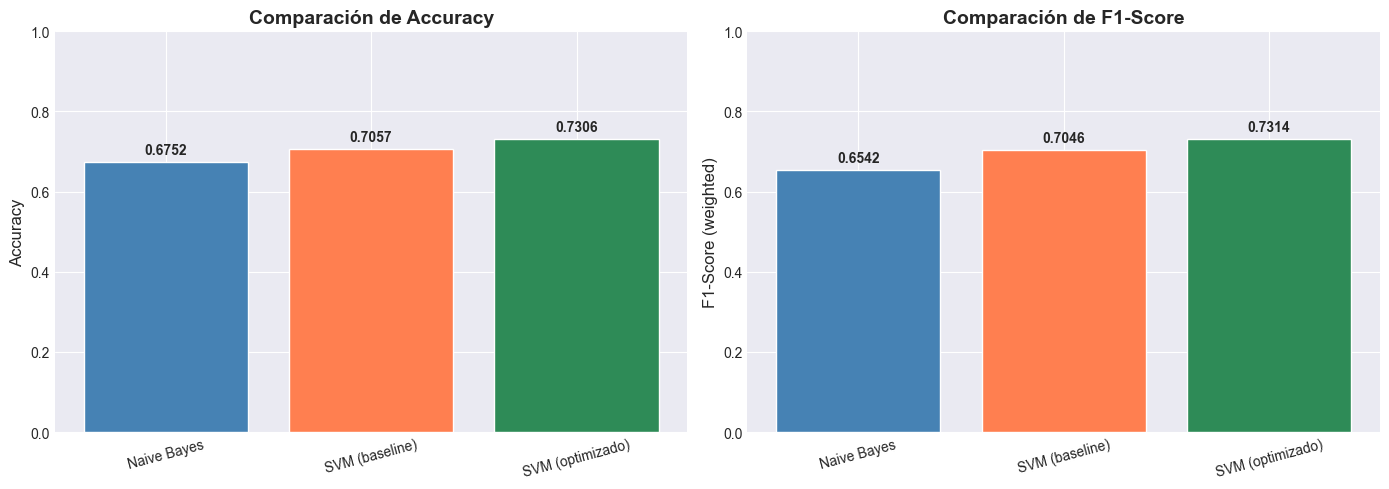


🏆 Mejor modelo: SVM (optimizado)


In [37]:
# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

print("📊 Comparación de Modelos:")
print(comparison_df.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].bar(comparison_df['Modelo'], comparison_df['Accuracy'], color=['steelblue', 'coral', 'seagreen'])
axes[0].set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# F1-Score
axes[1].bar(comparison_df['Modelo'], comparison_df['F1-Score'], color=['steelblue', 'coral', 'seagreen'])
axes[1].set_title('Comparación de F1-Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score (weighted)', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']
print(f"\n🏆 Mejor modelo: {best_model_name}")

🔄 Validación cruzada estratificada (5-fold)...

📊 Resultados de Validación Cruzada:
  Fold 1: 0.7219
  Fold 2: 0.7437
  Fold 3: 0.7372
  Fold 4: 0.7217
  Fold 5: 0.7257

📈 Estadísticas:
  Media:          0.7300
  Desv. Estándar: 0.0089
  Min:            0.7217
  Max:            0.7437


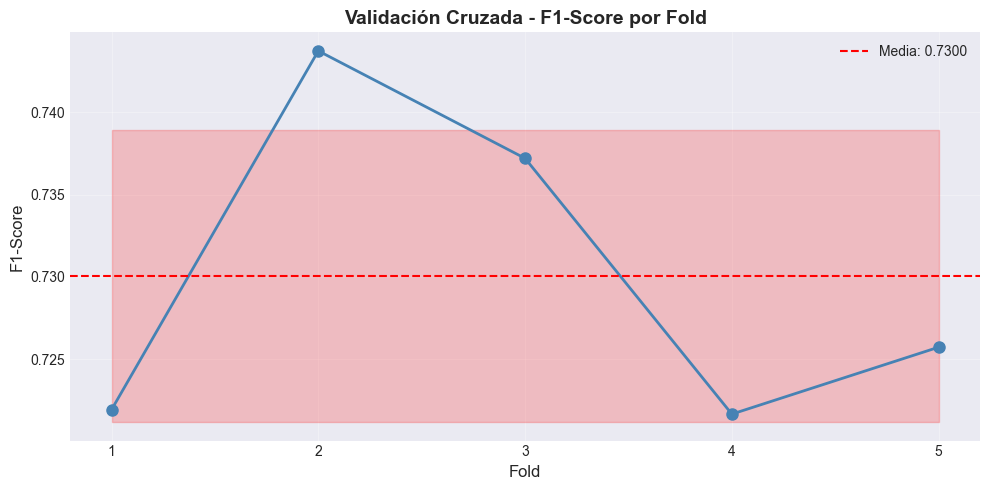

In [38]:
print("🔄 Validación cruzada estratificada (5-fold)...\n")

best_model = results[best_model_name]['model']

cv_scores = cross_val_score(
    best_model,
    X_train_vec,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"📊 Resultados de Validación Cruzada:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\n📈 Estadísticas:")
print(f"  Media:          {cv_scores.mean():.4f}")
print(f"  Desv. Estándar: {cv_scores.std():.4f}")
print(f"  Min:            {cv_scores.min():.4f}")
print(f"  Max:            {cv_scores.max():.4f}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Media: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(), alpha=0.2, color='red')
plt.title('Validación Cruzada - F1-Score por Fold', fontsize=14, fontweight='bold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔍 Analizando palabras más importantes por clase...

🏷️ Anxiety:
  restless               2.8458
  anxiety                2.6519
  worried                2.1825
  anxious                2.0859
  nervous                1.9235
  worry                  1.8464
  im                     1.4996
  restlessness           1.4177
  health                 1.3183
  ive                    1.2662

🏷️ Depression:
  depression             4.5411
  wa                     4.0516
  depressed              2.2047
  ha                     1.7159
  doe                    1.7091
  na                     1.4746
  depressive             1.1777
  wan                    1.1184
  le                     1.0555
  http                   0.9718

🏷️ Stress:
  stress                 3.2032
  tldr                   2.5877
  stressed               2.2058
  ptsd                   2.0952
  didnt                  2.0658
  couldnt                1.6560
  dont                   1.6325
  wasnt                  1.5934
  doesnt    

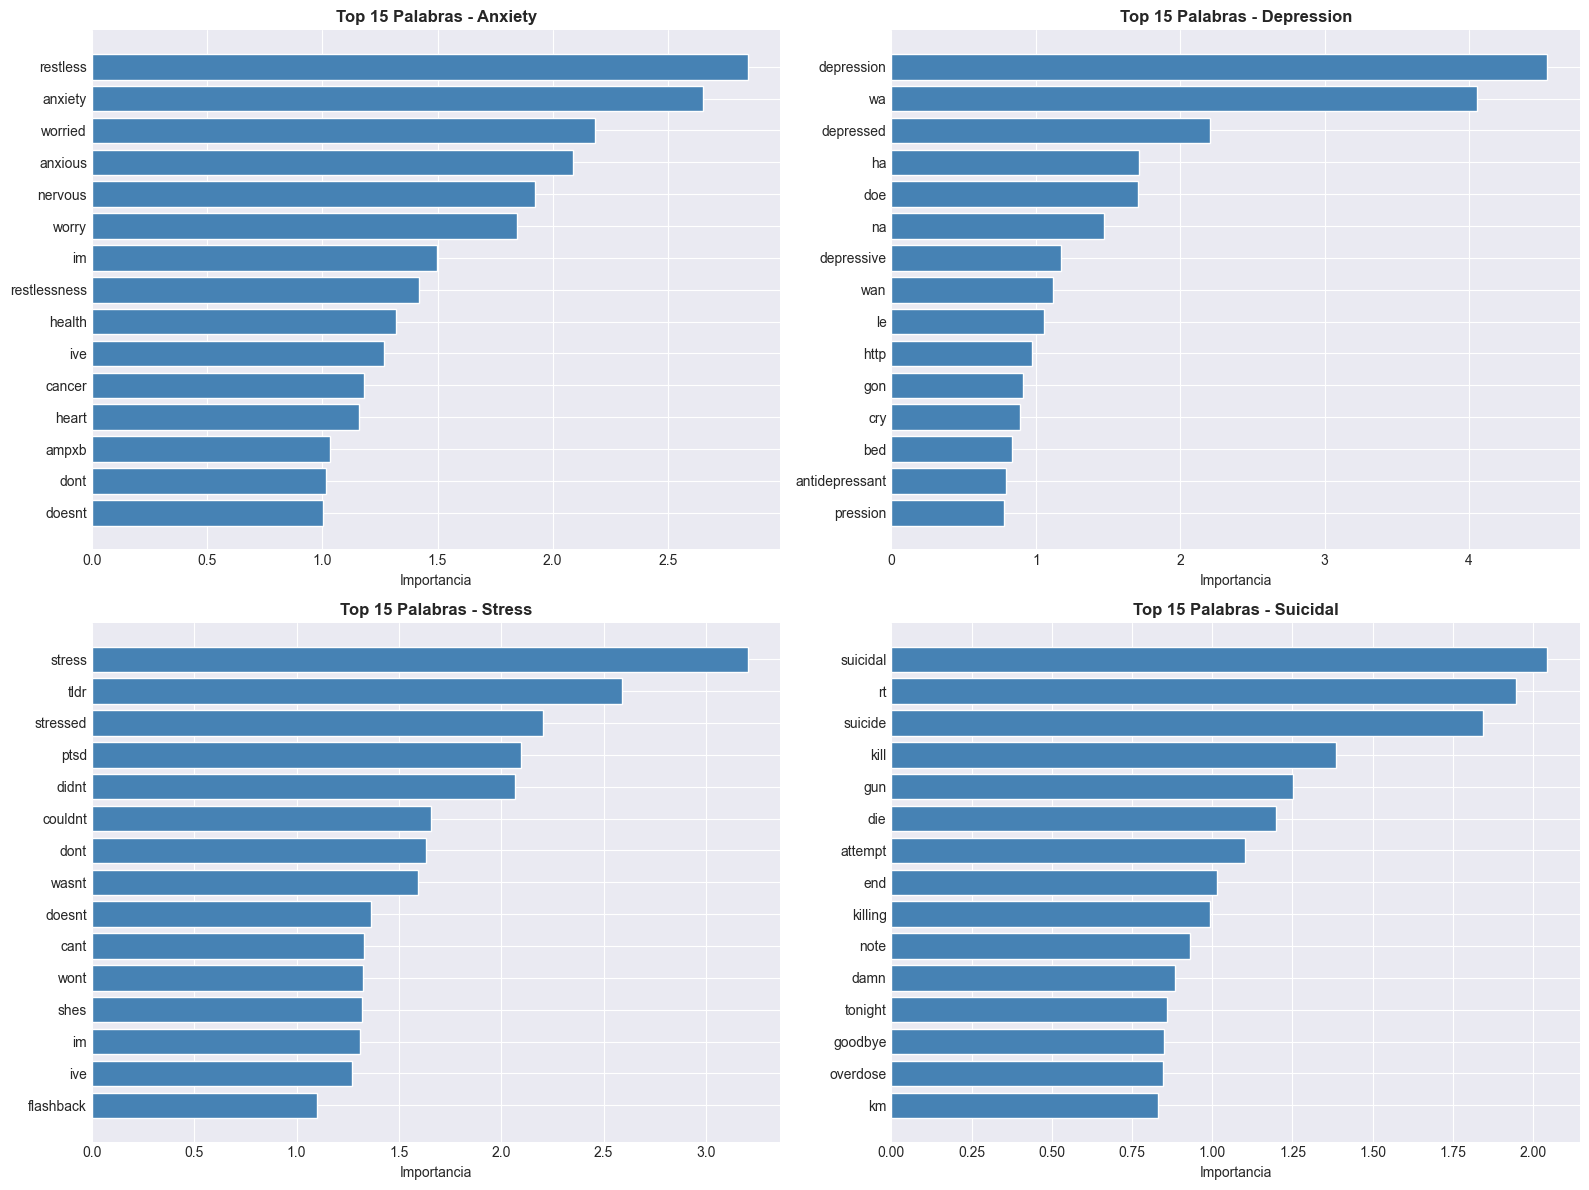

In [39]:
print("🔍 Analizando palabras más importantes por clase...\n")

feature_names = vectorizer.get_feature_names_out()
class_labels = best_model.classes_

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, class_label in enumerate(class_labels):
    coef = best_model.coef_[idx]
    top_indices = coef.argsort()[-15:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_coefs = [coef[i] for i in top_indices]

    axes[idx].barh(range(len(top_features)), top_coefs, color='steelblue')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features)
    axes[idx].set_xlabel('Importancia', fontsize=10)
    axes[idx].set_title(f'Top 15 Palabras - {class_label}', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()

    print(f"🏷️ {class_label}:")
    for word, score in zip(top_features[:10], top_coefs[:10]):
        print(f"  {word:20s} {score:8.4f}")
    print()

plt.tight_layout()
plt.show()

In [40]:
import os

os.makedirs("../../src/models/saved", exist_ok=True)

model_path = "../../src/models/saved/best_model.pkl"
joblib.dump(best_model, model_path)

print(f"✅ Modelo guardado en: {model_path}")
print(f"📊 Modelo: {best_model_name}")
print(f"📈 Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"📈 F1-Score: {results[best_model_name]['f1_score']:.4f}")

vectorizer_path = "../../src/models/saved/tfidf_vectorizer.pkl"
joblib.dump(vectorizer, vectorizer_path)
print(f"\n✅ Vectorizador guardado en: {vectorizer_path}")

print("\n🎉 ¡Entrenamiento completado exitosamente!")

✅ Modelo guardado en: ../src/models/saved/best_model.pkl
📊 Modelo: SVM (optimizado)
📈 Accuracy: 0.7306
📈 F1-Score: 0.7314

✅ Vectorizador guardado en: ../src/models/saved/tfidf_vectorizer.pkl

🎉 ¡Entrenamiento completado exitosamente!
